# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before

But how do you get your own data into PyTorch?

One of the ways to do is via : custom datasets.

## Domain libraries
Dpeneding on what you're working on, vision, text, audio. recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

**Resources :**
* Book version of the course materials for 04 : https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

# 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn, optim
from torch.fx.experimental.recording import shape_env_check_state_equal

print(torch.__version__)

2.5.1+cu124


In [2]:
!nvidia-smi

Sat Aug 16 19:28:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              9W /   35W |      53MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# setup agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

our datasets is a subset of the Food101 dataset

Food 101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary

The whole point is to speed up how fast you can experiment

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("../Datasets/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it..
if image_path.is_dir():
    print(f"{image_path} exists, skipping download")
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza steak sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi.zip")
    f.write(requests.content)

# unzip pissa sushi steak data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza_steak_sushi.zip")
    zip_ref.extractall(image_path)

../Datasets/pizza_steak_sushi exists, skipping download
Unzipping pizza_steak_sushi.zip


## 2. Becoming one with the data (data preperation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """
    walks through dir_path returning its contents
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '../Datasets/pizza_steak_sushi'.
There are 3 directories and 0 images in '../Datasets/pizza_steak_sushi/test'.
There are 0 directories and 25 images in '../Datasets/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in '../Datasets/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in '../Datasets/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in '../Datasets/pizza_steak_sushi/train'.
There are 0 directories and 78 images in '../Datasets/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '../Datasets/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in '../Datasets/pizza_steak_sushi/train/sushi'.


In [7]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../Datasets/pizza_steak_sushi/train'),
 PosixPath('../Datasets/pizza_steak_sushi/test'))

## 2.1 Visualize an image

write code for
1. get all of the image paths
2. pick a random path using python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with python's PIL
5. we'll then show the image and print metadata

sushi
Random image path : ../Datasets/pizza_steak_sushi/test/sushi/1245193.jpg
Image class : sushi
Image height : 295
Image width : 512


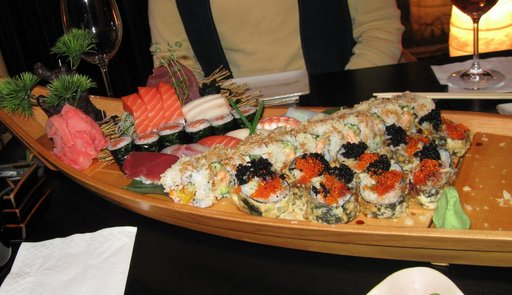

In [8]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get the image class from the path name (the image class is the name of the dir where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print meta data
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(294.5), np.float64(-0.5))

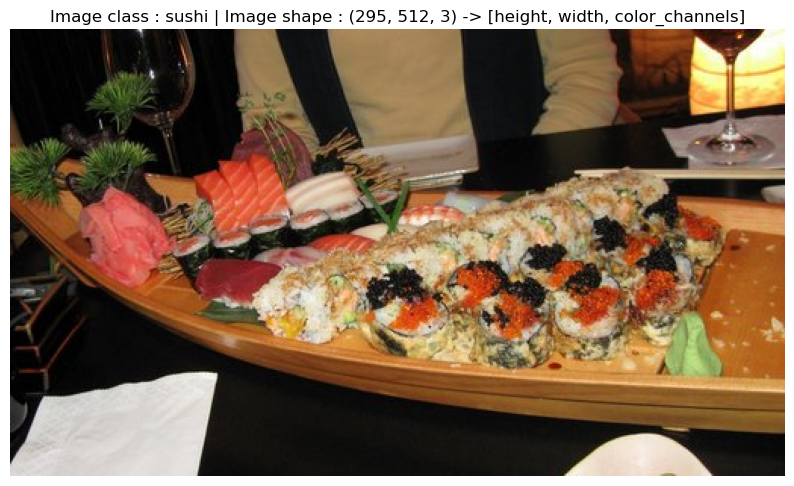

In [9]:
# use matplotlib
import matplotlib.pyplot as plt
import numpy as np

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)


In [10]:
img_as_array

array([[[  3,   3,   3],
        [  3,   3,   3],
        [  4,   4,   4],
        ...,
        [254, 250, 215],
        [251, 245, 211],
        [250, 241, 208]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  4,   4,   4],
        ...,
        [253, 250, 219],
        [255, 249, 221],
        [255, 250, 222]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  4,   4,   4],
        ...,
        [252, 250, 227],
        [255, 252, 236],
        [255, 253, 240]],

       ...,

       [[217, 213, 210],
        [217, 213, 210],
        [217, 213, 210],
        ...,
        [ 22,  21,  17],
        [ 20,  19,  15],
        [ 18,  17,  13]],

       [[219, 215, 212],
        [219, 215, 212],
        [220, 216, 213],
        ...,
        [ 23,  22,  18],
        [ 21,  20,  16],
        [ 19,  18,  14]],

       [[219, 215, 212],
        [219, 215, 212],
        [220, 216, 213],
        ...,
        [ 23,  22,  18],
        [ 22,  21,  17],
        [ 20,  19,  15]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. turn your target data into tensors (in our case, numerical representation of our images)
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.util.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://docs.pytorch.org/vision/stable/transforms.html

In [12]:
data_transform = transforms.Compose([
    # resize image
    transforms.Resize(size=(64, 64)),
    # flipping
    transforms.RandomHorizontalFlip(p=0.5),
    # turn to tensors
    transforms.ToTensor(),
])

In [13]:
data_transform(img).dtype

torch.float32

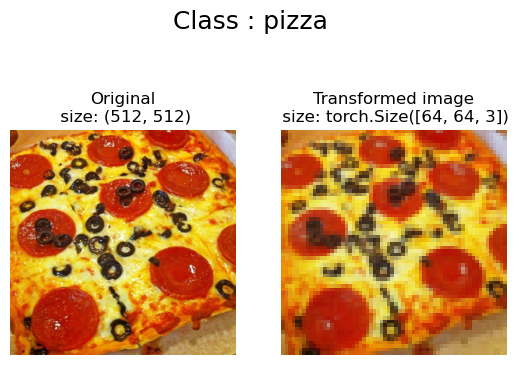

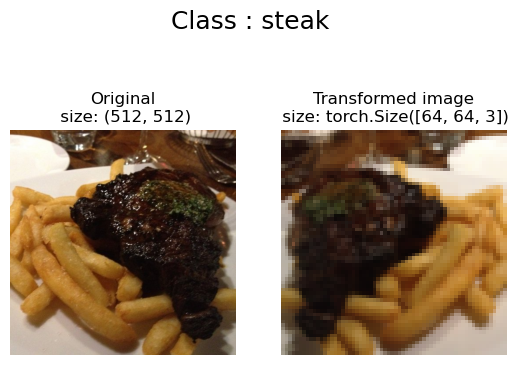

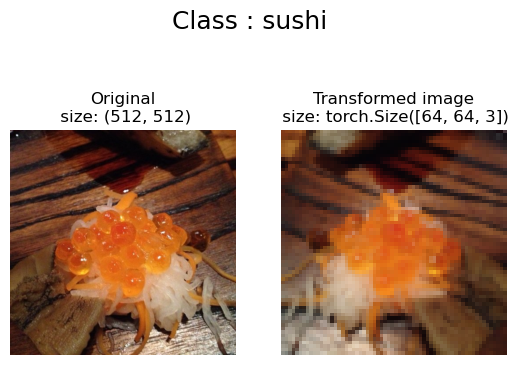

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/tranforms them then plots the original vs transformed version
    :param image_paths:
    :param transform:
    :param n:
    :param seed:
    :return:
    """
    if seed :
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\n size: {f.size}")
            ax[0].axis(False)

            # transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image\n size: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=18)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load imgae classification using `torchvision.datasets.ImgaeFolder` - https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [15]:
# use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ../Datasets/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ../Datasets/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('../Datasets/pizza_steak_sushi/train'),
 PosixPath('../Datasets/pizza_steak_sushi/test'))

In [17]:
# see classes names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# see classes names but in index
index_class_names = train_data.class_to_idx
index_class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
train_data.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [20]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape : {img.shape}")
print(f"Image label : {label}")
print(f"Image datatype : {img.dtype}")
print(f"Image tensor : \n{img}")
print(f"Label datatyoe : {type(label)}")

Image shape : torch.Size([3, 64, 64])
Image label : 0
Image datatype : torch.float32
Image tensor : 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.08

Original shape : torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted shape : torch.Size([64, 64, 3]) -> [color_channels, height, width]


Text(0.5, 1.0, 'pizza')

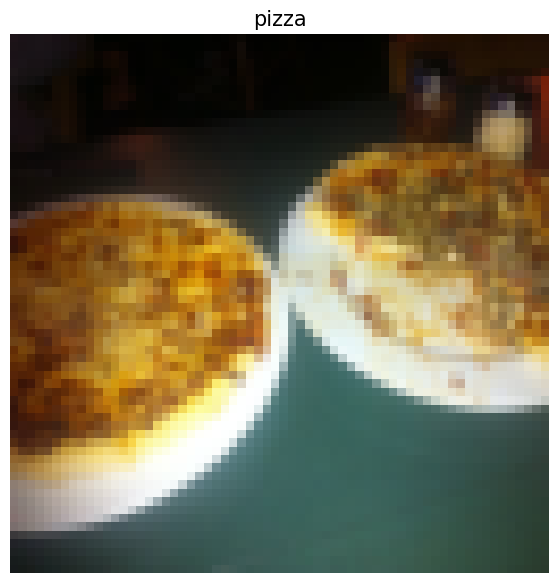

In [21]:
# Rearange the order of dimensions
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original shape : {img.shape} -> [color_channels, height, width]")
print(f"Permuted shape : {img_permute.shape} -> [color_channels, height, width]")

# plot the images
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=15)

### Turn loaded images into `Dataloader`

A `Dataloader` is going to help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time

In [22]:
# turn the train and test datasets into Dataloader format
train_daloader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=os.cpu_count())

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=os.cpu_count())

train_daloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc65f6a7af0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc65f6a7b50>)

In [23]:
len(train_daloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_daloader))

# batch size will now be 1, can change the batch size if you like

print(f"Image shape : {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape : torch.Size([1])


## 5. Option 2: Loading Image Data with a custom `dataset`

1. want to be able to load images from file
2. want to able to get class names from the dataset
3. want to be able to get classes as dictionary from the dataset

Pros :
- Can create a `Dataset` out of almost everything
- Not limited to PyTorch pre-built `Dataset` functions

Cons :
- eventhough you could create `Dataset` out of almost anything, it doesn't mean it will work...
- using a custom `dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [25]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Tuple, Dict

In [26]:
# instance of torchvision.Datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 creating a helper function to get class names

we want a function to:
1. get the class names using `os.scandir()`to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)
3. turn the class names into a dict and a list and return them

In [27]:
# setup path directory
target_directory = train_dir
print(f"Target directory : {target_directory}")

# get tge class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory : ../Datasets/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    finds the classes folder name in a target directory"""
    # 1. get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}... okease check file structure")

    # 3. Create a ditionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    return classes, class_to_idx


In [30]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

to create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. create several attributes:
   * paths - paths of our images
   * transform - the transform we'd like to use
   * classes - a list of the target classes
   * class_to_idx = a dict of the target classes mapped to integer labels
5. create a func to `load_images()`, this function will open an image
6. Overwrite the `__len()__` method to return the length of the datase
7. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [31]:
# 0. write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. initialize our custom dataset
    def __init__(self, targ_dir = str, transform = None):
        # create class attributes
        # get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # setup transform
        self.transform = transform
        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. create a func to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. overwritte __len__)
    def __len__(self) -> int:
        """returns the length of the dataset"""
        return len(self.paths)

    # 6. overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """return one sample of data , data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data folder/class_name/file_name.jpg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed image and label


In [32]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [34]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fc65f5670d0>,
 <__main__.ImageFolderCustom at 0x7fc65f565840>)

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
len(test_data), len(test_data_custom)

(75, 75)

In [37]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [38]:
# Check for equality between original ImageFolder dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10
3. set the random seed for reproducibility
4. get a list of random sample indexes from the target datase
5. setup a matplotlib plot
6. loop through the random sample images and plot them with matplotlib
7. make sure the dimensions of our images line up with matplotlib (height, width, color channel)

In [39]:
# 1. create a function to take in a dataset
def display_random_images(datasets: torch.utils.data.Dataset,
                          classes : List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    #2. adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print("For display, purposes, n should not be larger than 10, setting to 10 and removing shape display")

    # 3. set the seed
    if seed:
        random.seed(seed)

    # 4. get random sample indexes
    random_samples_idx = random.sample(range(len(datasets)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(15, 8))

    # 6. loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = datasets[targ_sample][0], datasets[targ_sample][1]

         # 7. adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [cc, h, w] -> [h, w, cc]

        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class : {classes[targ_label]}"
            if display_shape:
                title = title + f"\n shape : {targ_image_adjust.shape}"
        plt.title(title)

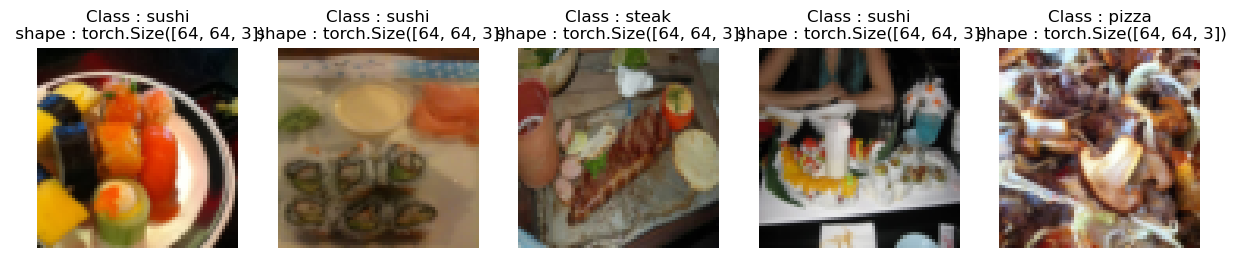

In [40]:
# display random images from the imagefolder created datase
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

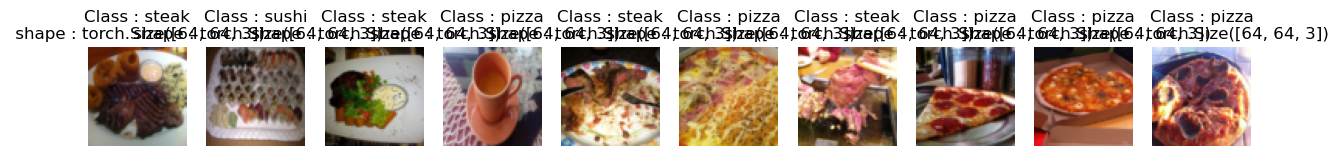

In [41]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=10,
                      classes=class_names_found,
                      seed=None)

### 5.4 turn custom loaded images into `DataLoader`s

In [42]:
from torch.utils.data import DataLoader
BS = 32
train_dataloader_custom = DataLoader(train_data_custom, batch_size=BS, shuffle=True, num_workers=0)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=BS, shuffle=False, num_workers=0)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fc65e93bac0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc65e93bb50>)

In [43]:
# get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data

In the case of image data, this may mean applying various image transformations to the training images

This practice hopefully results in a model that's more generalizable to unseen data

let's take a look at one particular type of data augmentation used to train PyTorch vision models to SOTA levels...

blog post : https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [44]:
# let's look at trivialaugment - https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.TrivialAugmentWide.html#torchvision.transforms.v2.TrivialAugmentWide

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [45]:
image_path

PosixPath('../Datasets/pizza_steak_sushi')

In [46]:
# get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('../Datasets/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('../Datasets/pizza_steak_sushi/test/pizza/344397.jpg')]

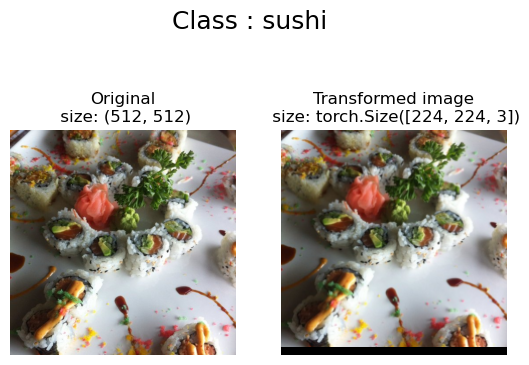

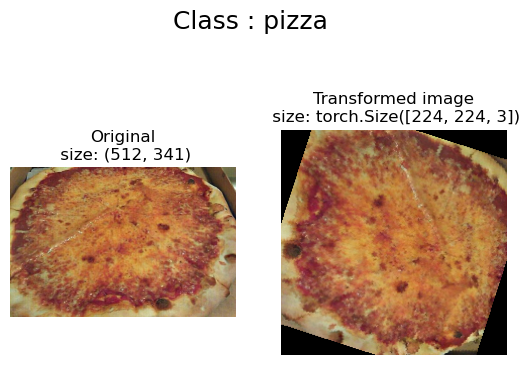

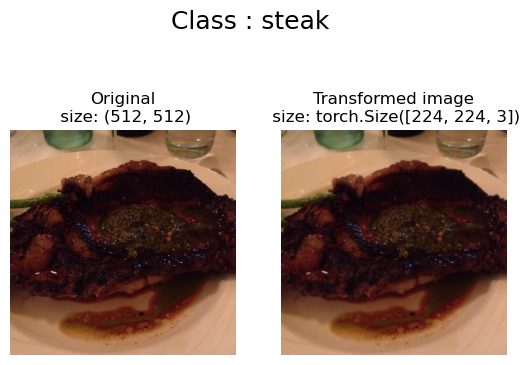

In [47]:
# plot random transfromed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n=3,
    seed = None
)

## 7. Model 0 : TinyVGG without data augmentation

let's replicate TinyVGG architecture from the CNN explainer website

### 7.1 Creating transforms and loading data for model 0

In [48]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [49]:
# 1. load and transform data
from torchvision import transforms, datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# setup BS and num_workers
BS = 32
NUM_WORKERS = os.cpu_count()

# create DataLoaders
train_dataloader_simple = DataLoader(train_data_simple, batch_size=BS, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple, batch_size=BS, num_workers=NUM_WORKERS, shuffle=False)


### 7.2 Create TinyVGG model class

In [50]:
from torch import nn

class TinyVGG(nn.Module):
    """
    Model architecture copying from TinyVGG from CNN explainer
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion -> https://horace.io/brrr_intro.html

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_waw = TinyVGG(input_shape = 3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape = len(class_names)).to(device)
model_waw

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [52]:
### 7.3 try a forward pass on a single image (to test the model)
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
# try a forward pass
print(model_waw(image_batch.to(device)))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9128e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1814e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1851e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

## 7.4 use `torchinfo` to get an idea of the shapes going through our model

In [54]:
from torchinfo import summary

summary(model_waw, input_size=(BS, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 7.4 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test)step()` - takes in a model and dataloader and evaluates the model of the dataloader

In [57]:
# create train_step()
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
    # put the model in train mode
    model.train()

    #setup train loss and train accuracy values
    train_loass, train_acc = 0, 0

    # loop through dataloader data batches
    for batch, (X, y) in enumerate(dataloader) :
        X, y = X.to(device), y.to(device)

        # 1. forward oass
        y_pred = model(X)

        # 2. calc the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # calc accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return train_loss, test_acc

In [58]:
# create a test step
def test_step(model: nn.Module,
        dataloader: DataLoader,
        loss_fn: nn.Module,
              device: device):
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # turn on inference mode
    with torch.inference_mode:
        # loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            test_pred_logits = model(X)

            # 2. calc the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # calc the acc
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # adjust metrics to get avg loss and acc per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc